In [1]:
import torch

# Test indices saved properly

In [25]:
dataset = 'imagenet'
layer_num = 9
neuron_num = 0
subtype = 'hook_mlp_out'
sampling_type = 'avg'
interval = 'top'
file_name = 'indices_and_activations.pt'

file_path = f'/network/scratch/s/sonia.joseph/CLIP_AUDIT/sampled_images/open-clip_laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/{dataset}/train/all_neurons/layer_{layer_num}/neuron_{neuron_num}/{subtype}/{sampling_type}/{interval}/'

In [26]:
# open .pt file

indices_and_activations = torch.load(file_path + file_name)
indices_and_activations

{'indices': [784570,
  194545,
  1176252,
  784109,
  192562,
  84083,
  784128,
  784554,
  1034317,
  784732,
  785011,
  462185,
  784353,
  785289,
  784348,
  785104,
  784845,
  784803,
  785326,
  784194],
 'activations': array([0.52573395, 0.5301386 , 0.54035866, 0.5433882 , 0.54766   ,
        0.54838985, 0.5496471 , 0.5546688 , 0.5609801 , 0.5624831 ,
        0.567077  , 0.56942725, 0.57426524, 0.57504046, 0.5873052 ,
        0.59995854, 0.6249186 , 0.75060374, 0.78736305, 0.8294963 ],
       dtype=float32)}

In [27]:
from clip_audit.dataloader.conceptual_captions import load_conceptual_captions
from clip_audit.utils.load_imagenet import load_imagenet

if dataset == 'conceptual_captions':
    conceptual_captions = load_conceptual_captions('train')
elif dataset == 'imagenet':
    path = '/network/scratch/s/sonia.joseph/datasets/kaggle_datasets'
    dataloader = load_imagenet(path, 'train')

In [28]:
indices_and_activations

{'indices': [784570,
  194545,
  1176252,
  784109,
  192562,
  84083,
  784128,
  784554,
  1034317,
  784732,
  785011,
  462185,
  784353,
  785289,
  784348,
  785104,
  784845,
  784803,
  785326,
  784194],
 'activations': array([0.52573395, 0.5301386 , 0.54035866, 0.5433882 , 0.54766   ,
        0.54838985, 0.5496471 , 0.5546688 , 0.5609801 , 0.5624831 ,
        0.567077  , 0.56942725, 0.57426524, 0.57504046, 0.5873052 ,
        0.59995854, 0.6249186 , 0.75060374, 0.78736305, 0.8294963 ],
       dtype=float32)}

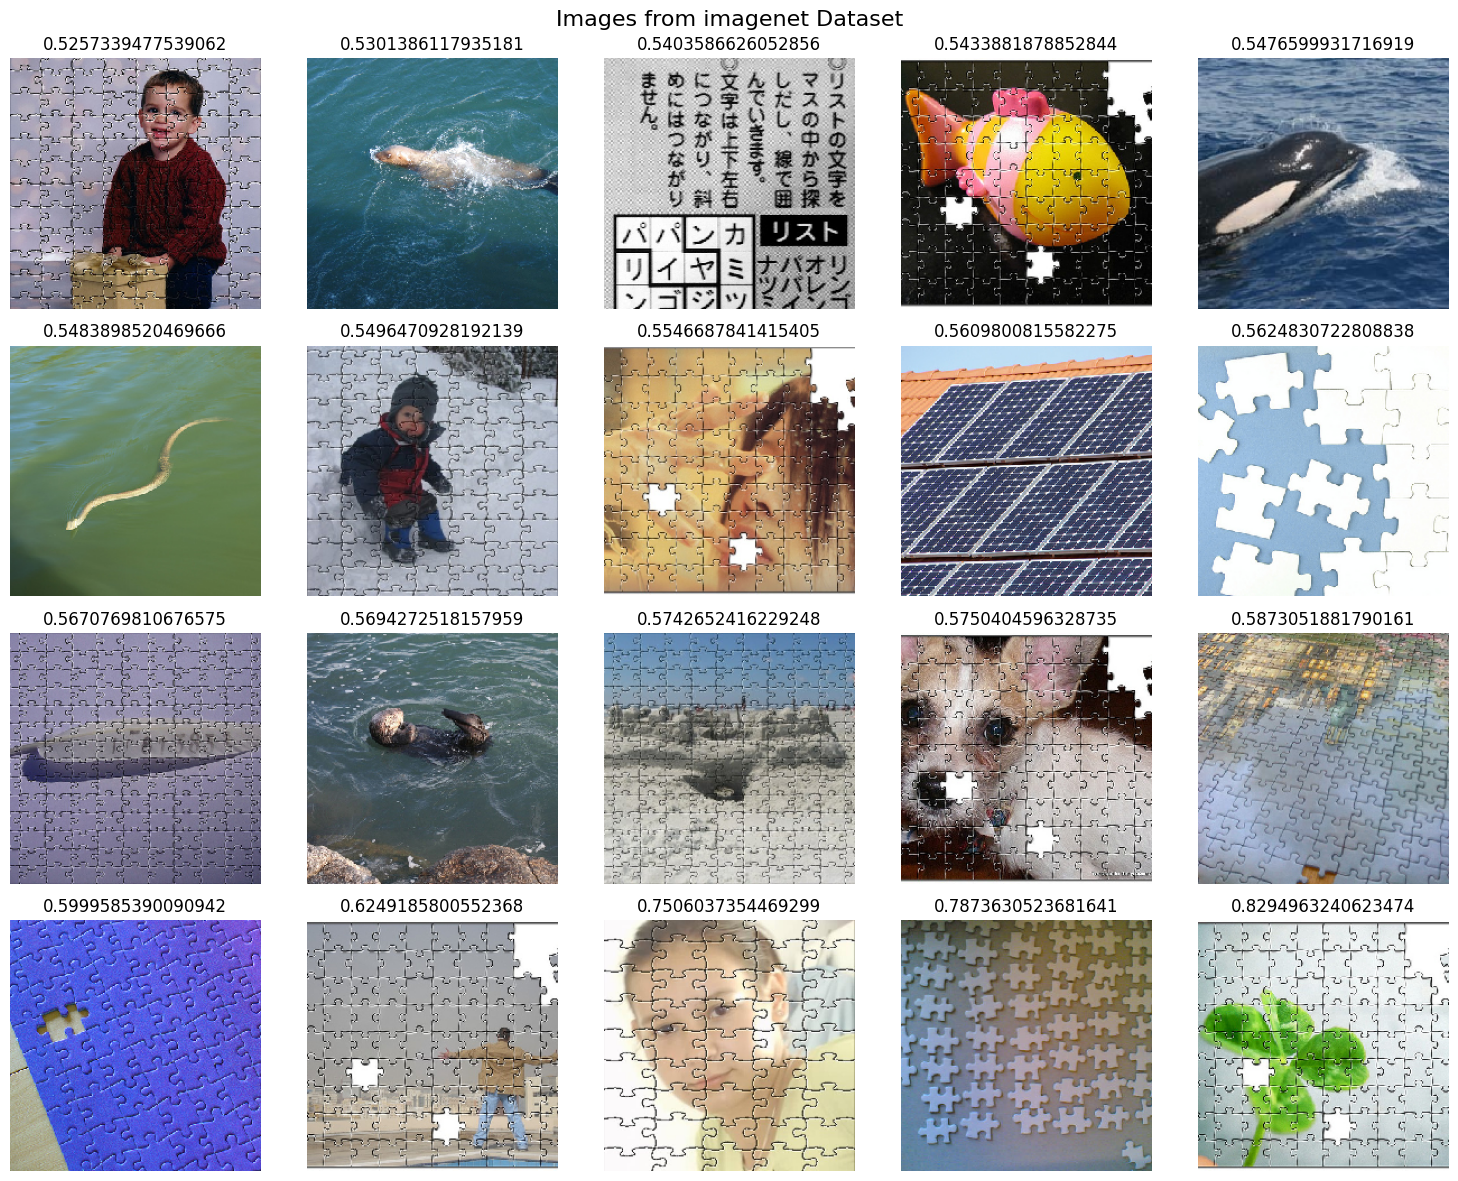

In [35]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image


# Create a figure with 4x5 subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 12), facecolor='white')
fig.suptitle(f'Images from {dataset} Dataset', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

def get_clip_val_transforms_display(image_size=224):
    """
    Transform for display that preserves the visual quality of the image
    """
    return transforms.Compose([
        transforms.Resize(size=image_size, interpolation=InterpolationMode.NEAREST),
        transforms.CenterCrop(size=(image_size, image_size)),
        # No need for ToTensor() and permute since we want to keep the image displayable
    ])

# Loop through 20 indices
for i, (act, idx) in enumerate(zip(indices_and_activations['activations'], indices_and_activations['indices'])):
    # Get image tensor
    if dataset == 'conceptual_captions':
        image = dataloader.dataset[idx]['image']
        caption = dataloader.dataset[idx]['caption']
    elif dataset == 'imagenet':
        image = dataloader.dataset[idx][0]
        caption = None

    display_transform = get_clip_val_transforms_display()
    
    # img_pil = transforms.CenterCrop(224)(img_pil)
    if isinstance(image, Image.Image):
        display_image = display_transform(image)
    else:
        img = image.permute(1, 2, 0).numpy()
        display_image = (img - img.min()) / (img.max() - img.min())
    
    
    # Plot on corresponding subplot with white background
    axes[i].imshow(display_image)
    axes[i].axis('off')
    axes[i].set_title(f'{act}')
    axes[i].patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# Test CLIP index mapping is correct

In [36]:
# now confirm we can map neuron back to original neuron
import numpy as np
from clip_audit.dataloader.conceptual_captions import load_conceptual_captions

# clip_index_mapping = np.load('../saved_data/clip_base_mlp_out.npy', allow_pickle=True).item()
if subtype =='hook_resid_post':
    clip_index_mapping = np.load('../saved_data/clip_base_residual_post.npy', allow_pickle=True).item()
elif subtype == 'hook_mlp_out':
    clip_index_mapping = np.load('../saved_data/clip_base_mlp_out.npy', allow_pickle=True).item()

In [37]:
def get_neuron_idx(layer_idx, neuron_num, neuron_dict):
    """
    Maps layer index and neuron number to the actual neuron index.
    
    Args:
        layer_idx (int): The layer index (key in the OrderedDict)
        neuron_num (int): Number from 0 to 29
        neuron_dict (OrderedDict): The dictionary mapping layers to neuron indices
    
    Returns:
        int: The actual neuron index
        
    Raises:
        ValueError: If neuron_num is not between 0 and 29
        KeyError: If layer_idx is not in the dictionary
    """
    if not 0 <= neuron_num <= 29:
        raise ValueError("neuron_num must be between 0 and 29")
    
    if layer_idx not in neuron_dict:
        raise KeyError(f"layer_idx {layer_idx} not found in dictionary")
    
    return neuron_dict[layer_idx][neuron_num]


old_neuron_num = get_neuron_idx(layer_num, neuron_num, clip_index_mapping)
old_neuron_num

572

In [38]:
# Now let's check CLIP with the validation to see if this is indeed the case
from vit_prisma.models.base_vit import HookedViT

model_name = 'open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K'
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True)


model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


In [39]:
val_dataset = load_conceptual_captions('val')
val_dataloader = load_imagenet(path, 'val')

Loading validation dataset
Found 15840 annotations in TSV file
Successfully loaded image files from cache
Successfully loaded 13204 valid image-annotation pairs from cache


In [11]:
from collections import defaultdict
import heapq
from tqdm import tqdm


def track_top_activations(model, dataset, layer_num, neuron_num, subtype=None, top_k=20, max_samples=50000):
    """
    Tracks top activations with global indices across the entire dataset.
    Automatically determines batch size from activations.
    
    Args:
        model: The model to run
        dataset: The dataset to iterate through
        layer_num (int): Layer number
        neuron_num (int): Neuron number
        subtype (str): Type of activation to look at
        top_k (int): Number of top activations to track
    
    Returns:
        list: Top k (activation value, global_idx) tuples
    """
    cache_key = f'blocks.{layer_num}.{subtype}'
    top_activations = []  # Will use as a min heap

    samples = 0
    
    for dataset_idx, sample in tqdm(enumerate(dataset)):
        image = sample['image']
        
        
        # Run model with caching
        _, cache = model.run_with_cache(image, names_filter=[cache_key])
        activations = cache[cache_key][:,:,neuron_num]  # Shape: [batch_size, seq_len]

        # this is just testing mean
        activations = activations.mean(dim=1)

        
        # Get batch size from activations
        batch_size = activations.shape[0]
        
        # For each position in the batch, get the max activation
        for batch_pos in range(batch_size):
            pos_activation = float(activations[batch_pos].max())
            
            # Calculate global index
            global_idx = dataset_idx * batch_size + batch_pos
            
            # If we haven't seen k examples yet, or if this activation is larger than smallest in heap
            if len(top_activations) < top_k:
                heapq.heappush(top_activations, (pos_activation, global_idx))
            elif pos_activation > top_activations[0][0]:
                heapq.heapreplace(top_activations, (pos_activation, global_idx))

        samples += batch_size
        if samples >= max_samples:
            break
        
        # Print progress every 1000 samples
        if dataset_idx % 1000 == 0:
            print(f"Processed {dataset_idx} samples...")
            current_top = sorted(top_activations, reverse=True)[:3]
            print(f"Current top 3 activations: {current_top}")
    
    # Sort in descending order
    return sorted(top_activations, reverse=True)

top_act_and_idx = track_top_activations(model, val_cc, layer_num=layer_num, subtype=subtype, neuron_num=old_neuron_num, max_samples=50000)

for activation, global_idx in top_act_and_idx:
    print(f"Activation: {activation:.4f}, Global Index: {global_idx}")


top_indices = [idx for _, idx in top_act_and_idx]


1it [00:08,  8.05s/it]

Processed 0 samples...
Current top 3 activations: [(0.17215263843536377, 79), (0.1384303718805313, 147), (0.12706948816776276, 163)]


3it [00:25,  8.48s/it]


KeyboardInterrupt: 

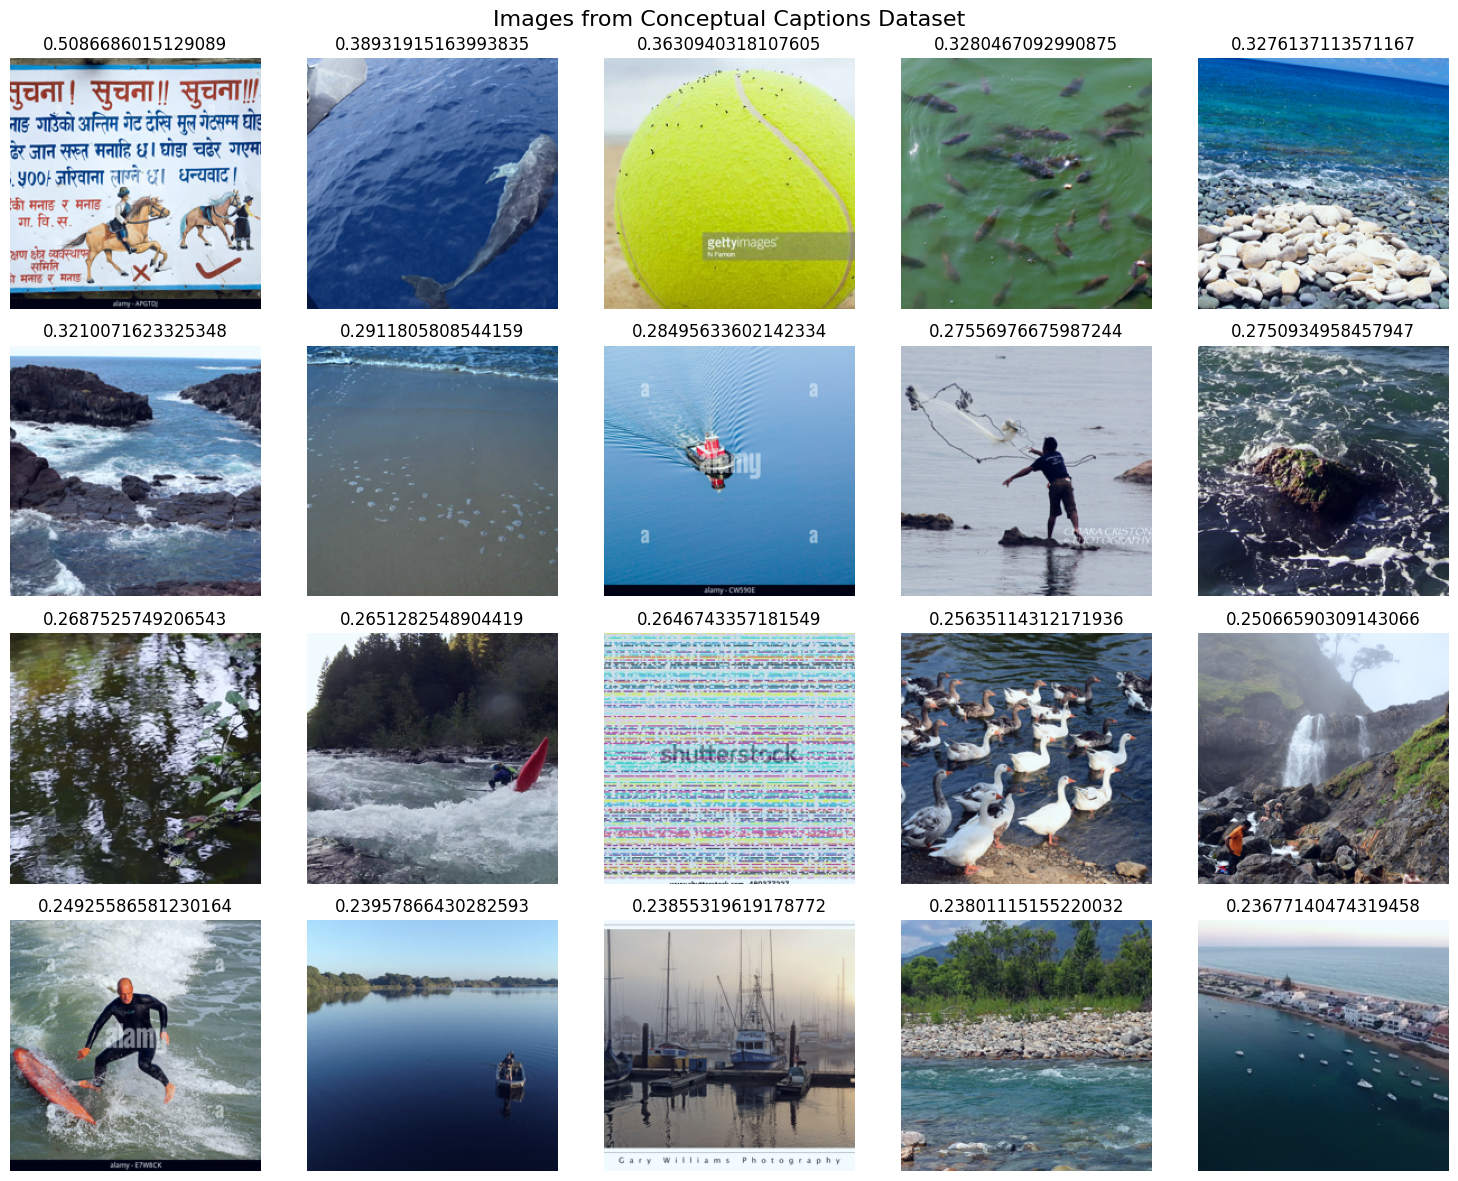

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 4x5 subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 12), facecolor='white')
fig.suptitle('Images from Conceptual Captions Dataset', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through 20 indices
for i, (act, idx) in enumerate(top_act_and_idx):
    # Get image tensor
    image = val_cc.dataset[idx]['image']
    caption = val_cc.dataset[idx]['caption']
    
    image = image.permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    
    # Plot on corresponding subplot with white background
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'{act}')
    axes[i].patch.set_facecolor('white')

plt.tight_layout()
plt.show()